<a href="https://colab.research.google.com/github/samirapakravan/PyTorch/blob/main/ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation
The goal is to simplify and/or change the representation of an image into something that is more meaningful and easier to analyze.

Image segmentation is typically used to locate objects and boundaries (lines, curves, etc.) in images. More precisely, image segmentation is the process of assigning a label to every pixel in an image such that pixels with the same label share certain characteristics.

This is an implementation of the algorithm proposed in the following paper:

> *   Olaf Ronneberger, Philipp Fischer, and Thomas Brox
 "[U-Net: Convolutional Networks for Biomedical
Image Segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" 



Note: 
Coursera Project Network with modifications

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=85c3a86a9413acfb2552de363787e92357ed878534ec9763d1f3194c80619e9a
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=cbc548ae83b2d6b29548af4cac1b6f537b97ffbc6e33949345c3b6cdce4f41d4
  Stored in directory: /root/.cache/pip/w

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 11.46 MiB/s, done.
Resolving deltas: 100% (3/3), done.


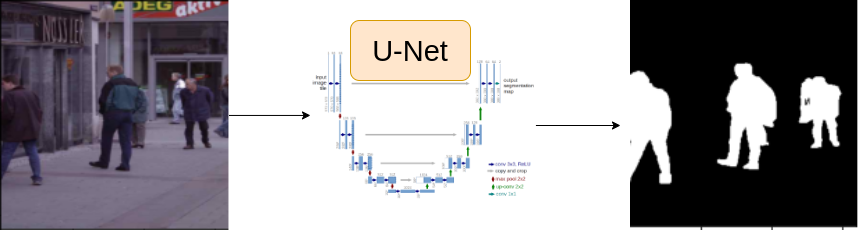

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

In [ ]:
# Backend for training:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Parameters
epochs = 30
batch_size = 32
lr = 0.001

In [ ]:
df = pd.read_csv(CSV_FILE)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   masks   290 non-null    object
 1   images  290 non-null    object
dtypes: object(2)
memory usage: 4.7+ KB


In [ ]:
image = df.iloc[0].images
image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # By default it is BGR

mask = df.iloc[0].masks
mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)

In [ ]:
image.shape

(183, 276, 3)

In [ ]:
mask.shape

(183, 276)

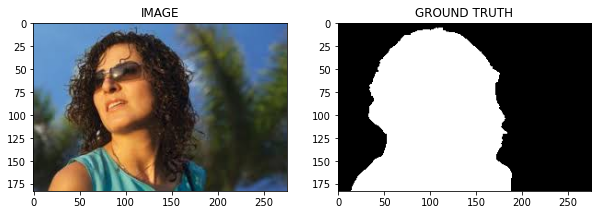

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
# split dataset
X_train, X_test = train_test_split(df, test_size=0.3)

In [ ]:
type(X_train)

pandas.core.frame.DataFrame

# Task 3 : Augmentation Functions

### What is image augmentation?
Deep neural networks require a lot of training data to obtain good results and prevent overfitting. However, it often very difficult to get enough training samples. Image augmentation is a process of creating new training examples from the existing ones.

Augmentations help to fight overfitting and improve the performance of deep neural networks for computer vision tasks such as classification, segmentation, and object detection.

### Note:

For classification we only apply augmentation on images and labels will not change.

For segmentation we need to change the ground truth or mask as well.

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
transform = A.Compose([
    A.Resize(width=320, height=320),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
], is_check_shapes = 0)

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, df, transform):
    self.df = df
    self.transform =  transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    image = self.df.iloc[idx].images
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

    mask = self.df.iloc[idx].masks
    mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)

    transformed = transform(image=image, mask=mask)
    transformed_image = transformed['image']
    transformed_mask = transformed['mask']

    # pytorch uses (c,h,w) our image is (h,w,c)
    transformed_image = np.transpose(transformed_image, (2,0,1)).astype(np.float32)
    transformed_mask = np.transpose(transformed_mask, (2,0,1)).astype(np.float32)

    transformed_image = torch.Tensor(transformed_image) / 255.0
    transformed_mask = torch.round(torch.Tensor(transformed_mask) / 255.0)
    #transformed_image = torch.transpose(transformed_image, (2,0,1))  # cannot be used
    #transformed_mask = torch.transpose(transformed_mask, (2,0,1))

    return transformed_image, transformed_mask


In [ ]:
X_train = CustomDataset(X_train, transform)
X_test = CustomDataset(X_test, transform)

In [ ]:
print(f"Size of Trainset : {len(X_train)}")
print(f"Size of Validset : {len(X_test)}")

Size of Trainset : 203
Size of Validset : 87


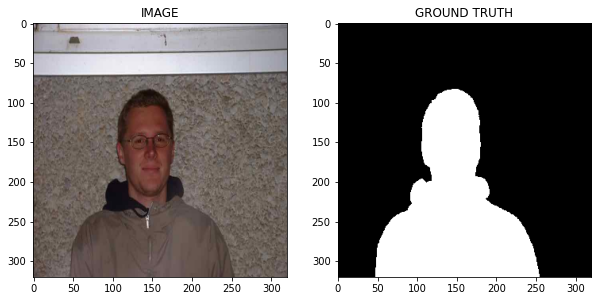

In [ ]:
image, mask = X_train[20]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_loader = DataLoader(dataset=X_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(dataset=X_test, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
print(f"num of batches in train: {len(train_loader)}, and test: {len(test_loader)}")

num of batches in train: 7, and test: 3


In [ ]:
for image, mask in train_loader:
  break

print(f"shape of one batch of image: {image.shape}, and test: {mask.shape}")

shape of one batch of image: torch.Size([32, 3, 320, 320]), and test: torch.Size([32, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
# using pytorch Segmentation Models
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss # for image segmentation task. It supports binary, multiclass and multilabel cases

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.arc = smp.Unet(
        encoder_name= 'timm-efficientnet-b0',  #  Name of the classification model that will be used as an encoder 
        encoder_weights= 'imagenet',  # One of None (random initialization), “imagenet” (pre-training on ImageNet) and other pretrained weights 
        in_channels=3,
        classes=1,   # since it's a binary segmentation problem
        activation= None  # No activation
    )

  def forward(self, images, masks=None):
    out = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(out, masks)
      loss2 = nn.BCEWithLogitsLoss()(out, masks)
      return out, loss1+loss2

    return out

In [ ]:
model = SegmentationModel()
model.to(device)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

In [ ]:
# Implementing the Unet, under construction

# Task 8 : Train Model

In [ ]:
optimizer =  torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
train_losses = []
test_losses = []

best_test_loss= np.Inf

for i in range(epochs):
  for images, masks in tqdm(train_loader):
    images =  images.to(device)
    masks = masks.to(device)

    out, loss = model(images, masks)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_losses.append(loss)
  print(f'Epoch:{i}, train_loss: {loss}')

  with torch.no_grad():
    for images, masks in tqdm(test_loader):
      images =  images.to(device)
      masks = masks.to(device)

      out, loss = model(images, masks)
    
    test_losses.append(loss)
    if loss < best_test_loss:
      torch.save(model.state_dict(), 'best_model.pt')
      print('MODEL SAVED')
      best_test_loss = loss



100%|██████████| 7/7 [00:05<00:00,  1.32it/s]


Epoch:0, train_loss: 0.8214766979217529


100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


MODEL SAVED


100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


Epoch:1, train_loss: 0.5615646839141846


100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


MODEL SAVED


100%|██████████| 7/7 [00:05<00:00,  1.26it/s]


Epoch:2, train_loss: 0.4960528612136841


100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


MODEL SAVED


100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


Epoch:3, train_loss: 0.45972156524658203


100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


MODEL SAVED


100%|██████████| 7/7 [00:05<00:00,  1.32it/s]


Epoch:4, train_loss: 0.21483591198921204


100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


Epoch:5, train_loss: 0.22190380096435547


100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


Epoch:6, train_loss: 0.277849406003952


100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch:7, train_loss: 0.17259636521339417


100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch:8, train_loss: 0.200892835855484


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


MODEL SAVED


100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


Epoch:9, train_loss: 0.15625913441181183


100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


Epoch:10, train_loss: 0.30715328454971313


100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


Epoch:11, train_loss: 0.10559999942779541


100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


Epoch:12, train_loss: 0.24526387453079224


100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch:13, train_loss: 0.10067139565944672


100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


Epoch:14, train_loss: 0.13241490721702576


100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


Epoch:15, train_loss: 0.12665531039237976


100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


Epoch:16, train_loss: 0.08854100108146667


100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


Epoch:17, train_loss: 0.07588278502225876


100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


Epoch:18, train_loss: 0.09357750415802002


100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch:19, train_loss: 0.09398169815540314


100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


Epoch:20, train_loss: 0.16320431232452393


100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


Epoch:21, train_loss: 0.09313149750232697


100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


Epoch:22, train_loss: 0.06570084393024445


100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch:23, train_loss: 0.07915991544723511


100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


Epoch:24, train_loss: 0.06907826662063599


100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch:25, train_loss: 0.19313962757587433


100%|██████████| 7/7 [00:05<00:00,  1.32it/s]


Epoch:26, train_loss: 0.05852614343166351


100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


Epoch:27, train_loss: 0.07891015708446503


100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


Epoch:28, train_loss: 0.060886964201927185


100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


Epoch:29, train_loss: 0.050647176802158356


100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


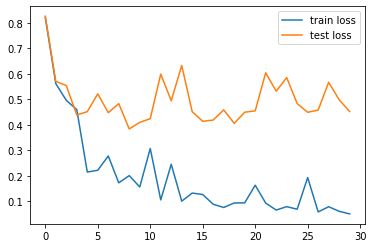

In [ ]:
import matplotlib.pyplot as plt

train_losses = [l.item() for l in train_losses]
test_losses = [l.item() for l in test_losses]
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

# Task 9 : Inference

In [ ]:
model.load_state_dict(torch.load('/content/best_model.pt'))

idx = 5
image, mask = X_test[idx]

out = model(image.to(device).unsqueeze(0)) # (C,H,W) --> (1,C,H,W)  to add batch dim
out = torch.sigmoid(out)

out = (out>0.5)*0.1

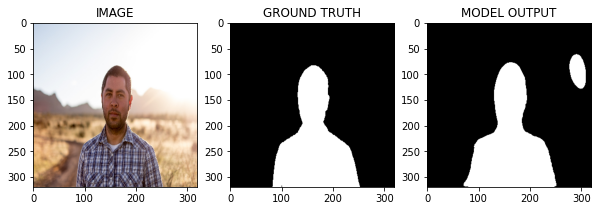

In [ ]:
helper.show_image(image, mask, out.detach().cpu().squeeze(0)) # bring back to cpu and remove the batch dim